In [1]:
import numpy as np
from scipy import signal 
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [2]:
def function_gen(x, a, b, c, d):
    y1 = a*x**2 +b*x+c
    y2 = d*x**3 + c*x**2 + b*x+a
    return y1, y2

In [3]:
x = np.linspace(0,1,100)

y1 = []
y2 = []
a = []
b = []
c = []
d = []

for i in range(10000):

    a_ = np.random.normal(8, 1.5, 1)
    b_ = np.random.normal(2, 2, 1)
    c_ = np.random.normal(4, 1, 1)
    d_ = np.random.normal(0, 0.5, 1)

    y1_, y2_ = function_gen(x, a_, b_, c_, d_)
    
    y1.append(y1_)
    y2.append(y2_)
    a.append(a_)
    b.append(b_)
    c.append(c_)
    d.append(d_)

In [4]:
reg1 = np.polyfit(x,y1[0],3)

In [5]:
reg1

array([-2.10519057e-14,  8.01856557e+00,  3.11987929e+00,  3.01943268e+00])

In [6]:
print(a[0],b[0],c[0],d[0])

[8.01856557] [3.11987929] [3.01943268] [-0.10578767]


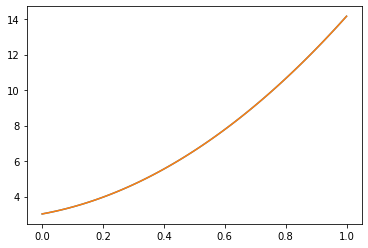

In [7]:
plt.plot(x, np.polyval(reg1,x))
plt.plot(x, y1[0])

In [8]:
reg2 = np.polyfit(x,y2[0],4)

In [9]:
reg2

array([-1.56926361e-14, -1.05787671e-01,  3.01943268e+00,  3.11987929e+00,
        8.01856557e+00])

In [10]:
print(a[0],b[0],c[0],d[0])

[8.01856557] [3.11987929] [3.01943268] [-0.10578767]


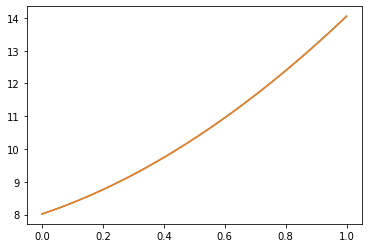

In [11]:
plt.plot(x, np.polyval(reg2,x))
plt.plot(x, y2[0])

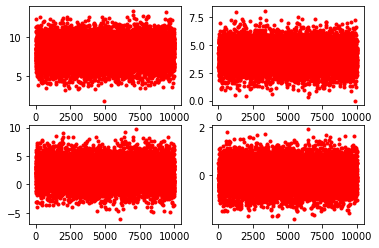

In [12]:
fig, axs = plt.subplots(ncols=2, nrows=2)

axs[0,0].plot(np.asarray(a),'r.')
axs[1,0].plot(np.asarray(b),'r.')
axs[0,1].plot(np.asarray(c),'r.')
axs[1,1].plot(np.asarray(d),'r.')

In [13]:
series1 = np.rollaxis(np.asarray(y1),1)
series2 = np.rollaxis(np.asarray(y2),1)

In [ ]:
# defines the model
model = Sequential()
model.add(Bidirectional())

In [14]:
import keras as K

Using TensorFlow backend.


In [18]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense


import keras
from keras.models import Sequential, Input, Model
from keras.layers import (Dense, Conv1D, Convolution2D, GRU, LSTM, Recurrent, Bidirectional, TimeDistributed,
                          Dropout, Flatten, RepeatVector, Reshape, MaxPooling1D, UpSampling1D, BatchNormalization)
from keras.layers.core import Lambda
from keras.optimizers import Adam
from keras.regularizers import l1


In [16]:
def rnn_auto(layer, size, num_encode_layers, num_decode_layers, embedding, n_step, lr = 3e-5, drop_frac=0.,bidirectional=True, l1_norm = 1e-4,**kwargs):
    """
    Function which builds the reccurrent neural network autoencoder
    Parameters
    ----------
    layer : string; options: 'lstm','gru'
        selects the layer type
    size  : numpy, int
        sets the size of encoding and decoding layers in the network
    num_encode_layers  : numpy, int
        sets the number of encoding layers in the network
    num_decode_layers : numpy, int
        sets the number of decoding layers in the network
    embedding : numpy, int
        sets the size of the embedding layer
    n_steps : numpy, int
        length of the input time series
    lr : numpy, float
        sets the learning rate for the model
    drop_frac : numpy, float
        sets the dropout fraction
    bidirectional : numpy, bool
        selects if the model is linear or bidirectional
    l1_norm : numpy. float
        sets the lambda value of the l1 normalization. The larger the value the greater the
        sparsity. None can be passed to exclude the use or l1 normailzation.
    Returns
    -------
    model : Keras, object
        Keras tensorflow model
    """

    # defines the model
    model = Sequential()

    # selects if the model is bidirectional
    if bidirectional:
        wrapper = Bidirectional
        # builds the first layer
        model.add(Bidirectional(layer(size, return_sequences=(num_encode_layers > 1),  dropout=drop_frac),
                            input_shape=(n_step, 1)))
    else:
        wrapper = lambda x: x
        # builds the first layer
        model.add(wrapper(layer(size, return_sequences=(num_encode_layers > 1),  dropout=drop_frac,
                input_shape=(n_step, 1))))

    # builds the encoding layers
    for i in range(1, num_encode_layers):
        model.add(wrapper(layer(size, return_sequences=(i < num_encode_layers - 1), dropout=drop_frac)))

    # builds the embedding layer
    if l1_norm == None:
        # embedding layer without l1 regulariization
        model.add(Dense(embedding, activation='relu', name='encoding'))
    else:
        # embedding layer with l1 regularization
        model.add(Dense(embedding, activation='relu', name='encoding',activity_regularizer=l1(l1_norm)))

    # builds the repeat vector
    model.add(RepeatVector(n_step))

    # builds the decoding layer
    for i in range(num_decode_layers):
        model.add(wrapper(layer(size, return_sequences=True, dropout=drop_frac)))

    # builds the time distributed layer to reconstruct the original input
    model.add(TimeDistributed(Dense(1, activation='linear')))

    # complies the model
    model.compile(Adam(lr), loss='mse')

    # returns the model
    return model

def train_model(model, data_train, data_test, path, epochs, batch_size):
    """
    Function which trains the neural network
    Parameters
    ----------
    model : Keras, object
        model to train
    data_train  : numpy, float
        data to train the network
    data_test  : numpy, float
        data to test the network
    path : string
        sets the folder to save the data
    epochs : numpy, int
        train the network for this number of epochs
    batch_size : numpy, int
        sets the size of the batch. Batch size should be as large as possible. The batch
        size is limited by the GPU memory.
    """

    #builds the filename
    filepath = path + '/weights.{epoch:02d}-{val_loss:.2f}.hdf5'
    # sets the control of checkpoints
    checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True,
                                             save_weights_only=True, mode='min', period=1)

    # fits the model
    model.fit(np.atleast_3d(data1), np.atleast_3d(data2), epochs=250000,
          batch_size=1200, validation_data=(np.atleast_3d(data), np.atleast_3d(data)),
          callbacks=[tbCallBack, checkpoint])


In [21]:
auto_test = rnn_auto(LSTM, 64, 1, 1, 10, 100)

W1007 15:30:23.504984 4394517952 deprecation_wrapper.py:119] From /Users/joshuaagar/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1007 15:30:23.509636 4394517952 deprecation_wrapper.py:119] From /Users/joshuaagar/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1007 15:30:24.219528 4394517952 deprecation_wrapper.py:119] From /Users/joshuaagar/anaconda3/lib/python3.7/site-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [ ]:
# fits the model
auto_test.fit(np.atleast_3d(y1), np.atleast_3d(y2), epochs=2500, batch_size=2000)

Epoch 1/2500
10000/10000 [==============================] - 6s 649us/step - loss: 91.2206
Epoch 2/2500
10000/10000 [==============================] - 6s 593us/step - loss: 89.5251
Epoch 3/2500
10000/10000 [==============================] - 6s 610us/step - loss: 87.7593
Epoch 4/2500
10000/10000 [==============================] - 6s 620us/step - loss: 85.9313
Epoch 5/2500
10000/10000 [==============================] - 6s 607us/step - loss: 84.0476
Epoch 6/2500
10000/10000 [==============================] - 6s 624us/step - loss: 82.1165
Epoch 7/2500
10000/10000 [==============================] - 6s 603us/step - loss: 80.1396
Epoch 8/2500
10000/10000 [==============================] - 6s 650us/step - loss: 78.1269
Epoch 9/2500
10000/10000 [==============================] - 6s 626us/step - loss: 76.0872
Epoch 10/2500
10000/10000 [==============================] - 6s 631us/step - loss: 74.0276
Epoch 11/2500
10000/10000 [==============================] - 6s 636us/step - loss: 71.9564
Epoch 12

10000/10000 [==============================] - 7s 665us/step - loss: 13.2390
Epoch 92/2500
10000/10000 [==============================] - 6s 621us/step - loss: 13.1126
Epoch 93/2500
10000/10000 [==============================] - 6s 639us/step - loss: 12.9923
Epoch 94/2500
10000/10000 [==============================] - 6s 625us/step - loss: 12.8755
Epoch 95/2500
10000/10000 [==============================] - 6s 626us/step - loss: 12.7647
Epoch 96/2500
10000/10000 [==============================] - 6s 608us/step - loss: 12.6577
Epoch 97/2500
10000/10000 [==============================] - 6s 617us/step - loss: 12.5551
Epoch 98/2500
10000/10000 [==============================] - 6s 613us/step - loss: 12.4568
Epoch 99/2500
10000/10000 [==============================] - 6s 617us/step - loss: 12.3626
Epoch 100/2500
10000/10000 [==============================] - 6s 610us/step - loss: 12.2729
Epoch 101/2500
10000/10000 [==============================] - 6s 615us/step - loss: 12.1868
Epoch 102/2

10000/10000 [==============================] - 6s 632us/step - loss: 8.9799
Epoch 181/2500
10000/10000 [==============================] - 6s 637us/step - loss: 8.9384
Epoch 182/2500
10000/10000 [==============================] - 6s 636us/step - loss: 8.8968
Epoch 183/2500
10000/10000 [==============================] - 7s 678us/step - loss: 8.8557
Epoch 184/2500
10000/10000 [==============================] - 7s 669us/step - loss: 8.8150
Epoch 185/2500
10000/10000 [==============================] - 6s 635us/step - loss: 8.7732
Epoch 186/2500
10000/10000 [==============================] - 6s 638us/step - loss: 8.7317
Epoch 187/2500
10000/10000 [==============================] - 6s 631us/step - loss: 8.6895
Epoch 188/2500
10000/10000 [==============================] - 6s 629us/step - loss: 8.6464
Epoch 189/2500
10000/10000 [==============================] - 6s 622us/step - loss: 8.6024
Epoch 190/2500
10000/10000 [==============================] - 6s 623us/step - loss: 8.5564
Epoch 191/2500

10000/10000 [==============================] - 7s 651us/step - loss: 5.0871
Epoch 271/2500
10000/10000 [==============================] - 7s 651us/step - loss: 5.0678
Epoch 272/2500
10000/10000 [==============================] - 7s 651us/step - loss: 5.0484
Epoch 273/2500
10000/10000 [==============================] - 7s 651us/step - loss: 5.0290
Epoch 274/2500
10000/10000 [==============================] - 7s 651us/step - loss: 5.0100
Epoch 275/2500
10000/10000 [==============================] - 6s 642us/step - loss: 4.9913
Epoch 276/2500
10000/10000 [==============================] - 7s 658us/step - loss: 4.9725
Epoch 277/2500
10000/10000 [==============================] - 6s 648us/step - loss: 4.9541
Epoch 278/2500
10000/10000 [==============================] - 7s 663us/step - loss: 4.9355
Epoch 279/2500
10000/10000 [==============================] - 6s 637us/step - loss: 4.9173
Epoch 280/2500
10000/10000 [==============================] - 6s 638us/step - loss: 4.8991
Epoch 281/2500

10000/10000 [==============================] - 6s 629us/step - loss: 3.7645
Epoch 361/2500
10000/10000 [==============================] - 6s 646us/step - loss: 3.7553
Epoch 362/2500
10000/10000 [==============================] - 7s 658us/step - loss: 3.7449
Epoch 363/2500
10000/10000 [==============================] - 7s 650us/step - loss: 3.7347
Epoch 364/2500
10000/10000 [==============================] - 6s 633us/step - loss: 3.7275
Epoch 365/2500
10000/10000 [==============================] - 6s 638us/step - loss: 3.7186
Epoch 366/2500
10000/10000 [==============================] - 6s 627us/step - loss: 3.7110
Epoch 367/2500
10000/10000 [==============================] - 6s 639us/step - loss: 3.6990
Epoch 368/2500
10000/10000 [==============================] - 6s 649us/step - loss: 3.6865
Epoch 369/2500
10000/10000 [==============================] - 6s 636us/step - loss: 3.6764
Epoch 370/2500
10000/10000 [==============================] - 7s 682us/step - loss: 3.6681
Epoch 371/2500

10000/10000 [==============================] - 7s 661us/step - loss: 3.0445
Epoch 451/2500
10000/10000 [==============================] - 7s 665us/step - loss: 3.0391
Epoch 452/2500
10000/10000 [==============================] - 7s 662us/step - loss: 3.0318
Epoch 453/2500
10000/10000 [==============================] - 6s 632us/step - loss: 3.0257
Epoch 454/2500
10000/10000 [==============================] - 6s 645us/step - loss: 3.0198
Epoch 455/2500
10000/10000 [==============================] - 6s 632us/step - loss: 3.0140
Epoch 456/2500
10000/10000 [==============================] - 6s 634us/step - loss: 3.0073
Epoch 457/2500
10000/10000 [==============================] - 6s 632us/step - loss: 3.0020
Epoch 458/2500
10000/10000 [==============================] - 6s 631us/step - loss: 2.9968
Epoch 459/2500
10000/10000 [==============================] - 6s 635us/step - loss: 2.9908
Epoch 460/2500
10000/10000 [==============================] - 7s 653us/step - loss: 2.9825
Epoch 461/2500

10000/10000 [==============================] - 6s 625us/step - loss: 2.5572
Epoch 541/2500
10000/10000 [==============================] - 6s 637us/step - loss: 2.5538
Epoch 542/2500
10000/10000 [==============================] - 6s 630us/step - loss: 2.5468
Epoch 543/2500
10000/10000 [==============================] - 6s 624us/step - loss: 2.5416
Epoch 544/2500
10000/10000 [==============================] - 6s 617us/step - loss: 2.5384
Epoch 545/2500
10000/10000 [==============================] - 6s 620us/step - loss: 2.5333
Epoch 546/2500
10000/10000 [==============================] - 6s 636us/step - loss: 2.5278
Epoch 547/2500
10000/10000 [==============================] - 6s 633us/step - loss: 2.5225
Epoch 548/2500
10000/10000 [==============================] - 6s 634us/step - loss: 2.5186
Epoch 549/2500
10000/10000 [==============================] - 6s 619us/step - loss: 2.5138
Epoch 550/2500
10000/10000 [==============================] - 6s 620us/step - loss: 2.5112
Epoch 551/2500

10000/10000 [==============================] - 7s 685us/step - loss: 2.0912
Epoch 631/2500
10000/10000 [==============================] - 7s 650us/step - loss: 2.0880
Epoch 632/2500
10000/10000 [==============================] - 6s 634us/step - loss: 2.0843
Epoch 633/2500
10000/10000 [==============================] - 6s 630us/step - loss: 2.0804
Epoch 634/2500
10000/10000 [==============================] - 6s 636us/step - loss: 2.0720
Epoch 635/2500
10000/10000 [==============================] - 7s 668us/step - loss: 2.0687
Epoch 636/2500
10000/10000 [==============================] - 7s 671us/step - loss: 2.0632
Epoch 637/2500
10000/10000 [==============================] - 7s 676us/step - loss: 2.0585
Epoch 638/2500
10000/10000 [==============================] - 7s 668us/step - loss: 2.0542
Epoch 639/2500
10000/10000 [==============================] - 7s 670us/step - loss: 2.0518
Epoch 640/2500
10000/10000 [==============================] - 7s 650us/step - loss: 2.0480
Epoch 641/2500

10000/10000 [==============================] - 6s 630us/step - loss: 1.7364
Epoch 721/2500
10000/10000 [==============================] - 6s 639us/step - loss: 1.7325
Epoch 722/2500
10000/10000 [==============================] - 6s 635us/step - loss: 1.7289
Epoch 723/2500
10000/10000 [==============================] - 6s 638us/step - loss: 1.7264
Epoch 724/2500
10000/10000 [==============================] - 6s 631us/step - loss: 1.7224
Epoch 725/2500
10000/10000 [==============================] - 6s 643us/step - loss: 1.7211
Epoch 726/2500
10000/10000 [==============================] - 6s 635us/step - loss: 1.7164
Epoch 727/2500
10000/10000 [==============================] - 6s 631us/step - loss: 1.7135
Epoch 728/2500
10000/10000 [==============================] - 6s 637us/step - loss: 1.7106
Epoch 729/2500
10000/10000 [==============================] - 6s 637us/step - loss: 1.7099
Epoch 730/2500
10000/10000 [==============================] - 6s 631us/step - loss: 1.7023
Epoch 731/2500

10000/10000 [==============================] - 7s 655us/step - loss: 1.4550
Epoch 811/2500
10000/10000 [==============================] - 7s 665us/step - loss: 1.4539
Epoch 812/2500
10000/10000 [==============================] - 7s 672us/step - loss: 1.4507
Epoch 813/2500
10000/10000 [==============================] - 7s 692us/step - loss: 1.4494
Epoch 814/2500
10000/10000 [==============================] - 7s 681us/step - loss: 1.4509
Epoch 815/2500
10000/10000 [==============================] - 7s 693us/step - loss: 1.4426
Epoch 816/2500
10000/10000 [==============================] - 7s 707us/step - loss: 1.4371
Epoch 817/2500
10000/10000 [==============================] - 7s 693us/step - loss: 1.4354
Epoch 818/2500
10000/10000 [==============================] - 7s 690us/step - loss: 1.4318
Epoch 819/2500
10000/10000 [==============================] - 7s 658us/step - loss: 1.4298
Epoch 820/2500
10000/10000 [==============================] - 7s 693us/step - loss: 1.4243
Epoch 821/2500

10000/10000 [==============================] - 7s 702us/step - loss: 1.2173
Epoch 901/2500
10000/10000 [==============================] - 7s 691us/step - loss: 1.2151
Epoch 902/2500
10000/10000 [==============================] - 7s 677us/step - loss: 1.2118
Epoch 903/2500
10000/10000 [==============================] - 7s 651us/step - loss: 1.2090
Epoch 904/2500
10000/10000 [==============================] - 7s 658us/step - loss: 1.2068
Epoch 905/2500
10000/10000 [==============================] - 7s 654us/step - loss: 1.2049
Epoch 906/2500
10000/10000 [==============================] - 7s 671us/step - loss: 1.2030
Epoch 907/2500
10000/10000 [==============================] - 7s 653us/step - loss: 1.1999
Epoch 908/2500
10000/10000 [==============================] - 6s 644us/step - loss: 1.1976
Epoch 909/2500
10000/10000 [==============================] - 6s 629us/step - loss: 1.1957
Epoch 910/2500
10000/10000 [==============================] - 6s 641us/step - loss: 1.1932
Epoch 911/2500

10000/10000 [==============================] - 7s 656us/step - loss: 1.0200
Epoch 991/2500
10000/10000 [==============================] - 6s 649us/step - loss: 1.0191
Epoch 992/2500
10000/10000 [==============================] - 6s 643us/step - loss: 1.0153
Epoch 993/2500
10000/10000 [==============================] - 6s 638us/step - loss: 1.0119
Epoch 994/2500
10000/10000 [==============================] - 6s 622us/step - loss: 1.0111
Epoch 995/2500
10000/10000 [==============================] - 7s 655us/step - loss: 1.0111
Epoch 996/2500
10000/10000 [==============================] - 6s 647us/step - loss: 1.0061
Epoch 997/2500
10000/10000 [==============================] - 6s 634us/step - loss: 1.0035
Epoch 998/2500
10000/10000 [==============================] - 6s 648us/step - loss: 1.0065
Epoch 999/2500
10000/10000 [==============================] - 6s 632us/step - loss: 1.0024
Epoch 1000/2500
10000/10000 [==============================] - 6s 641us/step - loss: 1.0019
Epoch 1001/25

10000/10000 [==============================] - 18s 2ms/step - loss: 0.8483
Epoch 1080/2500
10000/10000 [==============================] - 18s 2ms/step - loss: 0.8452
Epoch 1081/2500
10000/10000 [==============================] - 18s 2ms/step - loss: 0.8435
Epoch 1082/2500
10000/10000 [==============================] - 18s 2ms/step - loss: 0.8413
Epoch 1083/2500
10000/10000 [==============================] - 18s 2ms/step - loss: 0.8385
Epoch 1084/2500
10000/10000 [==============================] - 18s 2ms/step - loss: 0.8380
Epoch 1085/2500
10000/10000 [==============================] - 18s 2ms/step - loss: 0.8345
Epoch 1086/2500
10000/10000 [==============================] - 18s 2ms/step - loss: 0.8337
Epoch 1087/2500
10000/10000 [==============================] - 18s 2ms/step - loss: 0.8328
Epoch 1088/2500
10000/10000 [==============================] - 18s 2ms/step - loss: 0.8307
Epoch 1089/2500
10000/10000 [==============================] - 18s 2ms/step - loss: 0.8301
Epoch 1090/2500

10000/10000 [==============================] - 18s 2ms/step - loss: 0.6995
Epoch 1169/2500
10000/10000 [==============================] - 18s 2ms/step - loss: 0.7007
Epoch 1170/2500
10000/10000 [==============================] - 18s 2ms/step - loss: 0.7008
Epoch 1171/2500
10000/10000 [==============================] - 18s 2ms/step - loss: 0.6984
Epoch 1172/2500
10000/10000 [==============================] - 18s 2ms/step - loss: 0.6944
Epoch 1173/2500
10000/10000 [==============================] - 18s 2ms/step - loss: 0.6916
Epoch 1174/2500
10000/10000 [==============================] - 18s 2ms/step - loss: 0.6901
Epoch 1175/2500
10000/10000 [==============================] - 18s 2ms/step - loss: 0.6883
Epoch 1176/2500
10000/10000 [==============================] - 18s 2ms/step - loss: 0.6870
Epoch 1177/2500
10000/10000 [==============================] - 1130s 113ms/step - loss: 0.6866
Epoch 1178/2500
10000/10000 [==============================] - 11s 1ms/step - loss: 0.6843
Epoch 1179/

10000/10000 [==============================] - 18s 2ms/step - loss: 0.5876
Epoch 1258/2500
10000/10000 [==============================] - 1163s 116ms/step - loss: 0.5844
Epoch 1259/2500
10000/10000 [==============================] - 11s 1ms/step - loss: 0.5809
Epoch 1260/2500
10000/10000 [==============================] - 12s 1ms/step - loss: 0.5798
Epoch 1261/2500
10000/10000 [==============================] - 9s 910us/step - loss: 0.5780
Epoch 1262/2500
10000/10000 [==============================] - 6s 645us/step - loss: 0.5783
Epoch 1263/2500
10000/10000 [==============================] - 6s 649us/step - loss: 0.5760
Epoch 1264/2500
10000/10000 [==============================] - 7s 662us/step - loss: 0.5747
Epoch 1265/2500
10000/10000 [==============================] - 6s 650us/step - loss: 0.5751
Epoch 1266/2500
10000/10000 [==============================] - 7s 652us/step - loss: 0.5751
Epoch 1267/2500
10000/10000 [==============================] - 1566s 157ms/step - loss: 0.5727
E

10000/10000 [==============================] - 18s 2ms/step - loss: 0.4932
Epoch 1347/2500
10000/10000 [==============================] - 18s 2ms/step - loss: 0.4910
Epoch 1348/2500
10000/10000 [==============================] - 18s 2ms/step - loss: 0.4899
Epoch 1349/2500
10000/10000 [==============================] - 18s 2ms/step - loss: 0.4879
Epoch 1350/2500
10000/10000 [==============================] - 1151s 115ms/step - loss: 0.4849
Epoch 1351/2500
10000/10000 [==============================] - 7s 713us/step - loss: 0.4837
Epoch 1352/2500
10000/10000 [==============================] - 18s 2ms/step - loss: 0.4837
Epoch 1353/2500
10000/10000 [==============================] - 18s 2ms/step - loss: 0.4817
Epoch 1354/2500
10000/10000 [==============================] - 1586s 159ms/step - loss: 0.4814
Epoch 1355/2500
10000/10000 [==============================] - 9s 854us/step - loss: 0.4798
Epoch 1356/2500
10000/10000 [==============================] - 18s 2ms/step - loss: 0.4795
Epoch

10000/10000 [==============================] - 7s 736us/step - loss: 0.4103
Epoch 1436/2500
10000/10000 [==============================] - 6s 646us/step - loss: 0.4101
Epoch 1437/2500
10000/10000 [==============================] - 7s 654us/step - loss: 0.4080
Epoch 1438/2500
10000/10000 [==============================] - 6s 639us/step - loss: 0.4090
Epoch 1439/2500
10000/10000 [==============================] - 6s 637us/step - loss: 0.4071
Epoch 1440/2500
10000/10000 [==============================] - 6s 639us/step - loss: 0.4061
Epoch 1441/2500
10000/10000 [==============================] - 6s 640us/step - loss: 0.4036
Epoch 1442/2500
10000/10000 [==============================] - 6s 635us/step - loss: 0.4046
Epoch 1443/2500
10000/10000 [==============================] - 6s 622us/step - loss: 0.4027
Epoch 1444/2500
10000/10000 [==============================] - 6s 639us/step - loss: 0.4008
Epoch 1445/2500
10000/10000 [==============================] - 6s 636us/step - loss: 0.3998
Epoc

In [32]:
series1.shape

(100, 10000)

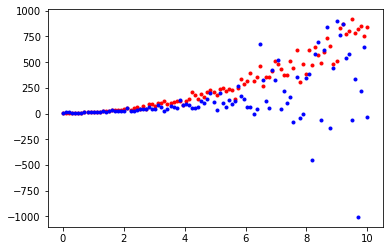

In [11]:
plt.plot(x,y1,'r.')
plt.plot(x,y2,'b.')

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RankWarning: Polyfit may be poorly conditioned
  """Entry point for launching an IPython kernel.


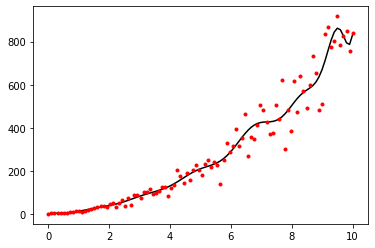

In [12]:
reg1 = np.polyfit(x,y1,20)
ry1 = np.polyval(reg1,x)
plt.plot(x,ry1,'k-')
plt.plot(x,y1,'r.')

In [13]:
reg1

array([-2.53752460e-09,  2.03033602e-07, -7.15180798e-06,  1.43085813e-04,
       -1.70399285e-03,  1.01357506e-02,  2.54981197e-02, -1.16128016e+00,
        1.24831786e+01, -8.23249216e+01,  3.78552641e+02, -1.26268815e+03,
        3.09175372e+03, -5.54744522e+03,  7.20732435e+03, -6.61808348e+03,
        4.10419022e+03, -1.57511588e+03,  3.22263171e+02, -1.82642032e+01,
        3.47442551e+00])

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RankWarning: Polyfit may be poorly conditioned
  """Entry point for launching an IPython kernel.


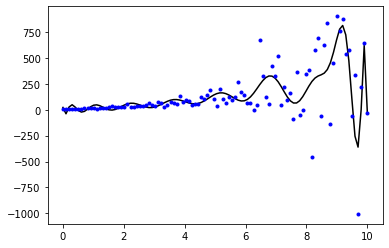

In [14]:
reg2 = np.polyfit(x,y2,20)
ry2 = np.polyval(reg2,x)
plt.plot(x,ry2,'k-')
plt.plot(x,y2,'b.')

In [15]:
reg2


array([-6.97317411e-08,  5.79305256e-06, -2.13429150e-04,  4.51222202e-03,
       -5.78371371e-02,  3.93827484e-01,  3.44075911e-01, -4.00690758e+01,
        4.91907082e+02, -3.61748527e+03,  1.85452119e+04, -6.92463746e+04,
        1.90476221e+05, -3.83954438e+05,  5.56956899e+05, -5.62998153e+05,
        3.76749405e+05, -1.53623351e+05,  3.29860537e+04, -2.70590661e+03,
        2.21043294e+01])

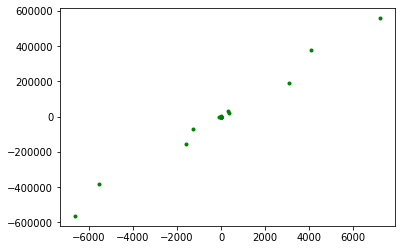

In [16]:
plt.plot(reg1,reg2,'g.')


In [17]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data
import imageio

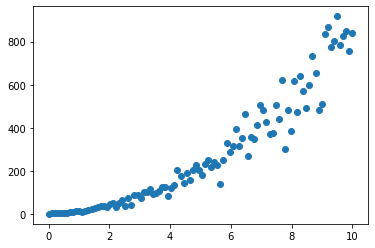

In [18]:
plt.scatter(x,y1,marker = 'o')

In [19]:
x1 = torch.from_numpy(x)
y11 = torch.from_numpy(y1)
x1=x1.double()


In [20]:
class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)   # hidden layer
        self.predict = torch.nn.Linear(n_hidden, n_output)   # output layer

    def forward(self, x):
        x = F.relu(self.hidden(x))      # activation function for hidden layer
        x = self.predict(x)             # linear output
        return x
    

In [21]:
net = Net(n_feature=100, n_hidden=3, n_output=100)     # define the network

optimizer = torch.optim.SGD(net.parameters(), lr=0.2)
loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss
net = net.double()

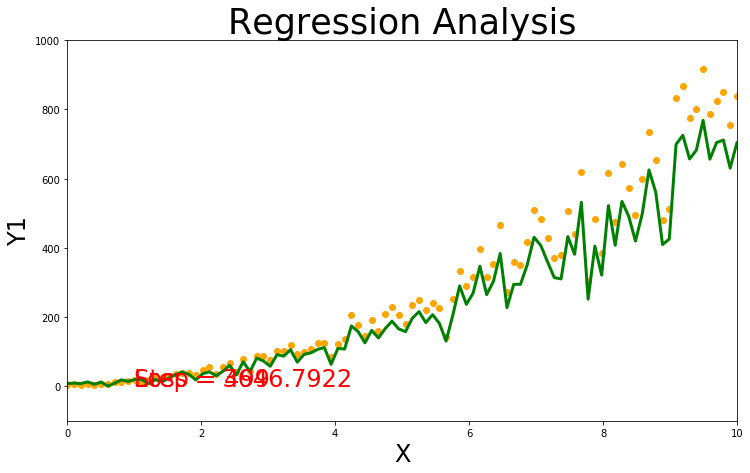

In [22]:
my_images = []
fig, ax = plt.subplots(figsize=(12,7))

for t in range(500):
  
    
    predication = net(x1)
    loss = loss_func(predication,y11)
    optimizer.zero_grad()   # clear gradients for next train
    loss.backward()         # backpropagation, compute gradients
    optimizer.step()        # apply gradients
    
    # plot and show learning process
    plt.cla()
    ax.set_title('Regression Analysis', fontsize=35)
    ax.set_xlabel('X', fontsize=24)
    ax.set_ylabel('Y1', fontsize=24)
    ax.set_xlim(0, 10)
    ax.set_ylim(-100, 1000)
    ax.scatter(x1.data.numpy(), y11.data.numpy(), color = "orange")
    ax.plot(x1.data.numpy(), predication.data.numpy(), 'g-', lw=3)
    ax.text(1.0, 0.1, 'Step = %d' % t, fontdict={'size': 24, 'color':  'red'})
    ax.text(1.0, 0, 'Loss = %.4f' % loss.data.numpy(),
            fontdict={'size': 24, 'color':  'red'})

    # Used to return the plot as an image array 
    # (https://ndres.me/post/matplotlib-animated-gifs-easily/)
    fig.canvas.draw()       # draw the canvas, cache the renderer
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    my_images.append(image)
    

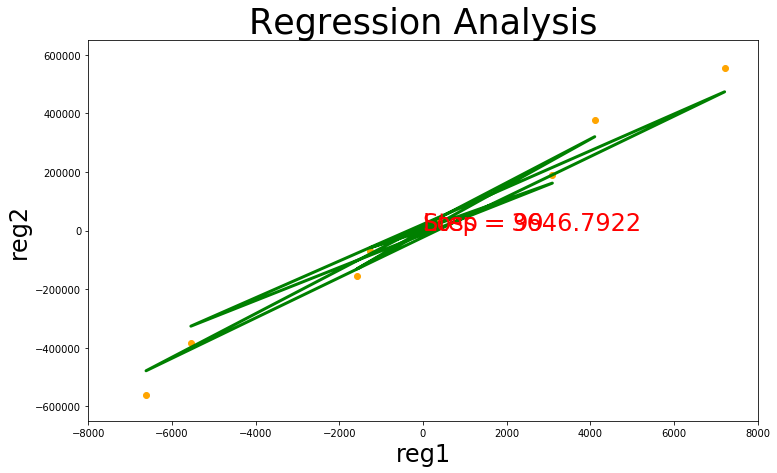

In [33]:
reg1_1 = torch.from_numpy(reg1)
reg2_1 = torch.from_numpy(reg2)
reg1_1 = reg1_1.double()
net1 = Net(n_feature=21, n_hidden=2, n_output=21)     # define the network

optimizer1 = torch.optim.SGD(net1.parameters(), lr=0.2)
loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss
net1 = net1.double()
my_images = []
fig1, ax = plt.subplots(figsize=(12,7))

for t in range(100):
  
    
    predication = net1(reg1_1)
    loss1 = loss_func(predication,reg2_1)
    optimizer1.zero_grad()   # clear gradients for next train
    loss1.backward()         # backpropagation, compute gradients
    optimizer1.step()        # apply gradients
    
    # plot and show learning process
    plt.cla()
    ax.set_title('Regression Analysis', fontsize=35)
    ax.set_xlabel('reg1', fontsize=24)
    ax.set_ylabel('reg2', fontsize=24)
    ax.set_xlim(-8000, 8000)
    ax.set_ylim(-650000, 650000)
    ax.scatter(reg1_1.data.numpy(), reg2_1.data.numpy(), color = "orange")
    ax.plot(reg1_1.data.numpy(), predication.data.numpy(), 'g-', lw=3)
    ax.text(1.0, 0.1, 'Step = %d' % t, fontdict={'size': 24, 'color':  'red'})
    ax.text(1.0, 0, 'Loss = %.4f' % loss.data.numpy(),
            fontdict={'size': 24, 'color':  'red'})

    # Used to return the plot as an image array 
    # (https://ndres.me/post/matplotlib-animated-gifs-easily/)
    fig1.canvas.draw()       # draw the canvas, cache the renderer
    image = np.frombuffer(fig1.canvas.tostring_rgb(), dtype='uint8')
    image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    my_images.append(image)

In [24]:
x_n = np.linspace(0,1,100)
y1_n, y2_n = function_gen(x_n, a,b,c,d)

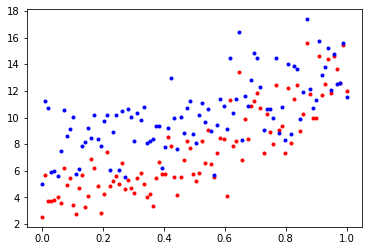

In [25]:
plt.plot(x_n,y1_n,'r.')
plt.plot(x_n,y2_n,'b.')

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RankWarning: Polyfit may be poorly conditioned
  """Entry point for launching an IPython kernel.


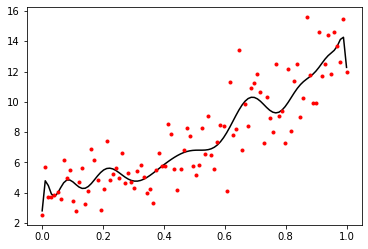

In [26]:
reg1_n = np.polyfit(x_n,y1_n,20)
ry1_n = np.polyval(reg1_n,x_n)
plt.plot(x_n,ry1_n,'k-')
plt.plot(x_n,y1_n,'r.')

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RankWarning: Polyfit may be poorly conditioned
  """Entry point for launching an IPython kernel.


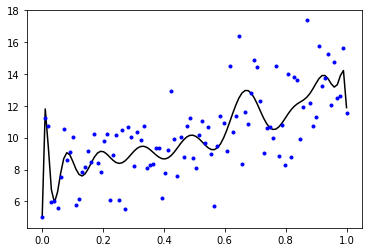

In [27]:
reg2_n = np.polyfit(x_n,y2_n,20)
ry2_n = np.polyval(reg2_n,x_n)
plt.plot(x_n,ry2_n,'k-')
plt.plot(x_n,y2_n,'b.')

In [28]:
reg1_n 

array([-4.84559773e+09,  3.63257082e+10, -1.16259491e+11,  1.99024267e+11,
       -1.72681810e+11,  1.30658707e+10,  1.32154537e+11, -1.19769195e+11,
       -7.14646623e+09,  1.04791994e+11, -1.10927598e+11,  6.71456736e+10,
       -2.72840492e+10,  7.76277294e+09, -1.55204584e+09,  2.13847229e+08,
       -1.94778553e+07,  1.09201764e+06, -3.33220738e+04,  4.39694969e+02,
        2.80154366e+00])

array([ 3.13083480e+10, -2.86793584e+11,  1.17021511e+12, -2.76145581e+12,
        4.02032140e+12, -3.31514220e+12,  4.06515420e+11,  2.81398690e+12,
       -4.24431075e+12,  3.60111627e+12, -2.10530142e+12,  8.95784033e+11,
       -2.81863855e+11,  6.54524620e+10, -1.10498299e+10,  1.31852248e+09,
       -1.06235100e+08,  5.36678030e+06, -1.49249498e+05,  1.73507043e+03,
        4.95629066e+00])

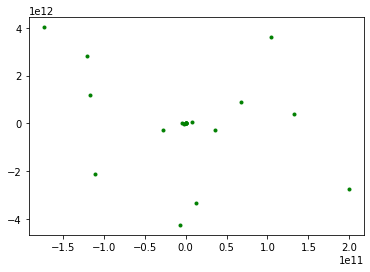

In [29]:
plt.plot(reg1_n,reg2_n,'g.')
reg2_n


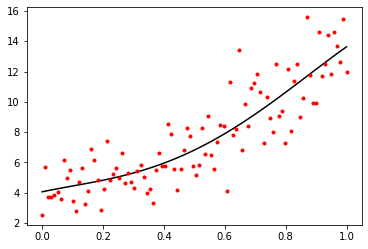

In [30]:
reg1_n1 = np.polyfit(x_n,y1_n,4)
reg2_n1 = np.polyfit(x_n,y2_n,4)
ry1_n1 = np.polyval(reg1_n1,x_n)
ry2_n1 = np.polyval(reg2_n1,x_n)
plt.plot(x_n,ry1_n1,'k-')
plt.plot(x_n,y1_n,'r.')

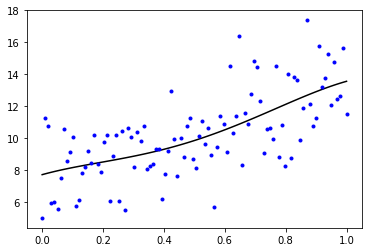

In [31]:
plt.plot(x_n,ry2_n1,'k-')
plt.plot(x_n,y2_n,'b.')

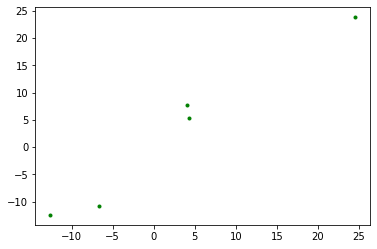

In [34]:
plt.plot(reg1_n1,reg2_n1,'g.')